In [2]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from pprint import pprint
from glob import glob
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [3]:
%load_ext autoreload
%autoreload 1
%aimport main
%aimport data_utils
%aimport contrastive_data
%aimport sc_eVIP.score


In [4]:
from contrastive_data import *
from data_utils import *
from main import *
from models import *
from scoring import *


In [5]:
from sc_eVIP import score as sceVIP_score

# Data

In [6]:
gene = 'TP53'
data_path = f'/home/lguirardel/data/perturb_comp/data/{gene}/'


In [7]:
group_wt_like = True
paths = get_paths(data_path)
counts = load_data(*paths, group_wt_like=False)

	Reading files...
		Reading matrix


		Reading genes and cells
		Reading variant data
	Merging and processing...
		99 variant classes


In [8]:
metadata = pd.read_csv(paths[4], index_col=0) # contains T2 scores and control status
metadata['Control status'].value_counts()
metadata['Variant functional class'] = metadata['Variant functional class'].replace('Impactful IV (gain-of-function)', 'Impactful IV')

In [9]:
control_status = metadata['Control status'].dropna().isin(['synonymous'])
control_status.value_counts()


Control status
False    85
True     16
Name: count, dtype: int64

Ursu et al subsampled to 1k cell/variant, which is conserved here

In [10]:
counts.variant.value_counts()

variant
A159P    1000
G266V    1000
H193L    1000
H193Y    1000
I195T    1000
         ... 
V157F     473
H214R     467
E339K     441
P58R      388
WT        356
Name: count, Length: 99, dtype: int64

# Utils

In [37]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [75]:
variant_class_cmap = {
    'Synonymous':'C7',
    'WT-like':'C4',
    'Impactful I':'C2',
    'Impactful II':'C5',

}
if gene == 'KRAS':
    variant_class_cmap.update({
            'Impactful III':'C6',
            'Impactful IV':'C3',
    })

def color_tick(ticklabel, ):
    variant = ticklabel.get_text()
    color = 'k'
    if control_status[variant ] :
        color = variant_class_cmap['Synonymous']
    else:
        color = variant_class_cmap[metadata.loc[variant, 'Variant functional class']]
        # if metadata.loc[variant, 'Variant functional class']=='WT-like':
        #     ticklabel.set_color('orange')   
    ticklabel.set_color(color)


# PCA

Reproduce results from Ursu et al. They used all data, and so will we here

In [70]:
pca = PCA(20)
df = counts.drop(columns=['variant','Variant functional class','cycle'])
X_red = pca.fit_transform(df)
X_red = pd.DataFrame(X_red, index = df.index)

In [40]:
result = sceVIP_score.compare_groups_with_reference(

    X_red,
    pd.DataFrame(counts.variant.rename('label')),
    groups=counts.variant.unique(),
    controls=control_status[control_status].index,
    n_bootstrap_controls=0
)

Found 15/15 controls
4 %

100 %

In [41]:
result

,HotellingT2.mean,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.high,avg.pearson.mean,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.high,HotellingT2.q,avg.pearson.q
A159V,243.711451,223.263065,264.159836,1.799159,1.777983,1.820336,0.000010,0.000010
WT,27.31515,22.283804,32.346496,0.058696,0.044938,0.072454,0.560933,0.526672
M237I,315.923304,289.983695,341.862913,1.321306,1.281957,1.360656,0.000010,0.000010
Y234C,220.309492,202.201436,238.417547,1.546925,1.509143,1.584706,0.000010,0.000010
G245C,325.096233,299.168407,351.024059,1.723449,1.703002,1.743896,0.000010,0.000010
...,...,...,...,...,...,...,...,...
R249S,319.181401,293.770439,344.592364,1.757022,1.723513,1.79053,0.000010,0.000010
Y220C,208.780044,192.662482,224.897605,1.476473,1.428632,1.524314,0.000010,0.000010
P250L,222.206988,205.652476,238.7615,1.830969,1.812865,1.849072,0.000010,0.000010
R158L,212.764841,196.165947,229.363735,1.562141,1.532325,1.591957,0.000010,0.000010


       Recomputed       Paper
T170T   23.114597   23.551053
R158R   24.765083   24.664665
P359P   25.825461   25.465182
P301P   25.916446   26.051759
D21D    26.157147   26.840234
...           ...         ...
V173M  370.190498  373.069919
G245D  377.849051  377.474615
P278S  375.073305  381.868154
R248Q         NaN         NaN
F338F         NaN         NaN

[102 rows x 2 columns]


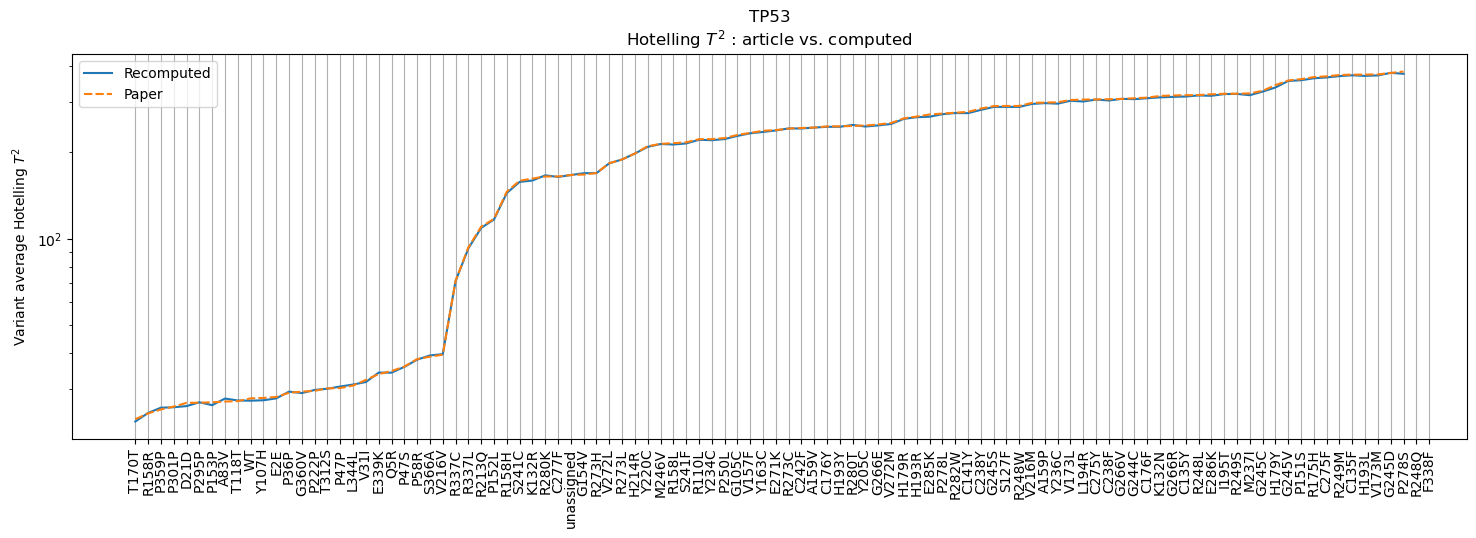

In [42]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.mean'].rename('Recomputed'), metadata['HotellingT2'].rename('Paper')), axis=1) #.dropna()
df = df.sort_values('Paper')
sns.lineplot(data=df, )
print(df)
plt.yscale('log')
plt.xticks(rotation=90)
plt.title(f'{gene}\nHotelling $T^2$ : article vs. computed')
plt.ylabel('Variant average Hotelling $T^2$')
plt.grid(axis='x');


In [43]:
df[df.isna().any(axis=1)]

,Recomputed,Paper
unassigned,NaN,166.613473
R248Q,NaN,NaN
F338F,NaN,NaN


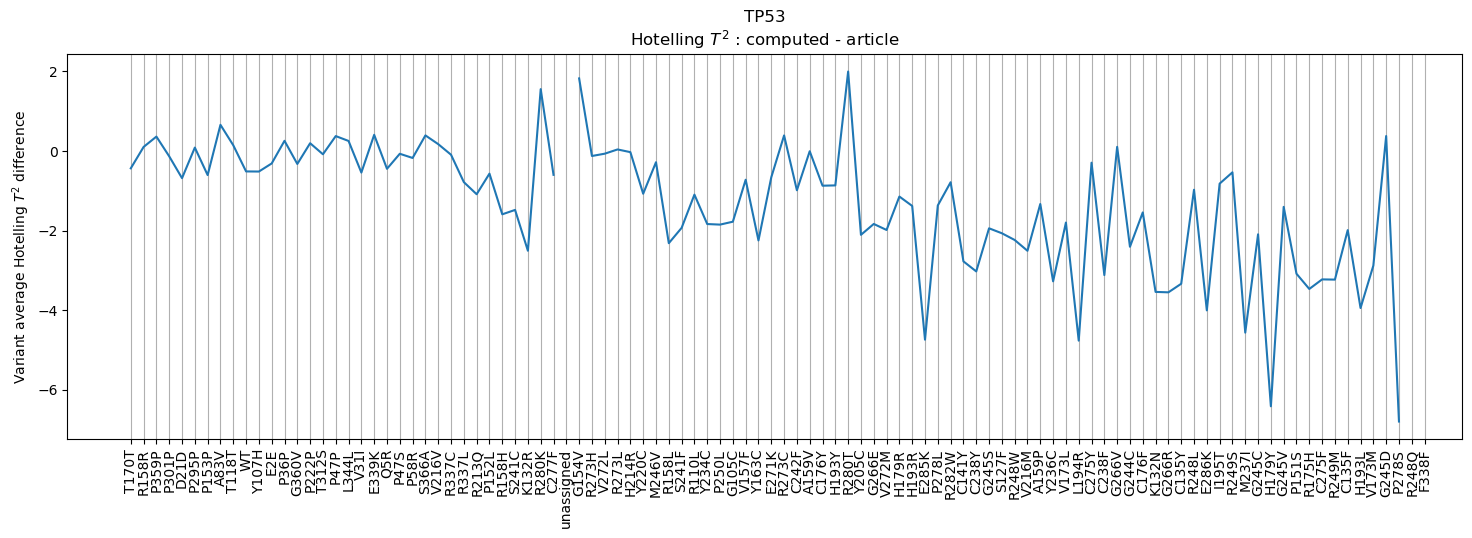

In [44]:
plt.gcf().set_size_inches(18, 5);
plt.xticks(rotation=90)
plt.grid(axis='x')
plt.plot(df.Recomputed - df.Paper)
plt.title(f'{gene}\nHotelling $T^2$ : computed - article')
plt.ylabel('Variant average Hotelling $T^2$ difference');

Nb : the difference observed here has some randomness. I suspect this might be due to the package used to compute Hotellings $T^2$. ~~I don't think it has a 0 expectancy, which means there's still likely to be something wrong.~~ It actually might have 0 expectancy, which means I might be worried for nothing

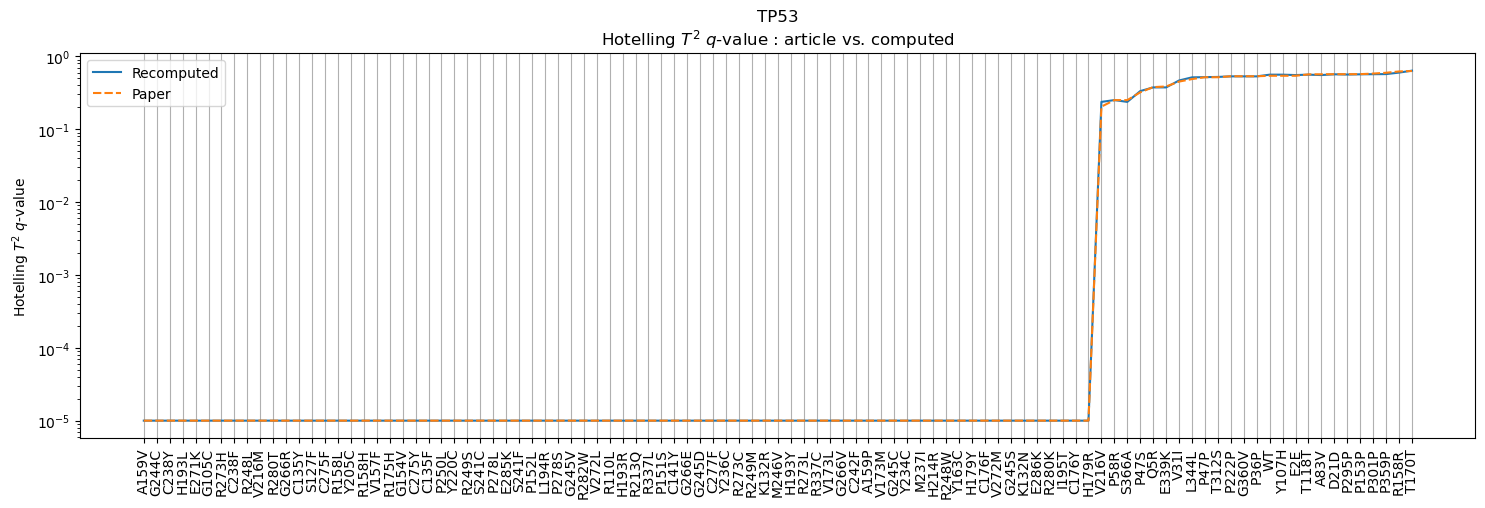

In [45]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.q'].rename('Recomputed'), metadata['HotellingT2.q'].rename('Paper')), axis=1).dropna()
df = df.sort_values('Paper')
sns.lineplot(data=df, )
# print(df)
plt.grid(axis='x')
plt.yscale('log')
plt.xticks(rotation=90)
plt.title(f'{gene}\nHotelling $T^2$ $q$-value : article vs. computed')
plt.ylabel('Hotelling $T^2$ $q$-value');

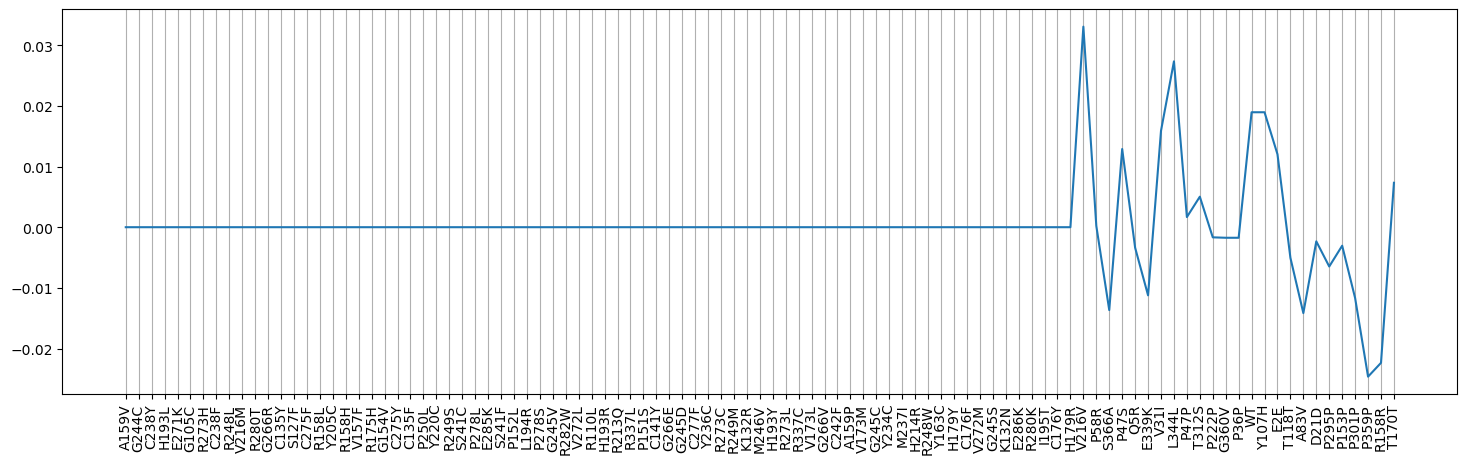

In [46]:
plt.gcf().set_size_inches(18, 5);
plt.xticks(rotation=90)
plt.grid(axis='x')
plt.plot(df.Recomputed - df.Paper)

## Dendrogram

In [86]:
# variant_avg = X_red.groupby(counts.variant).mean()
df =  counts.drop(columns=['Variant functional class','variant','cycle'])
df =( df - df.mean()) / df.std()
df = df.groupby(counts.variant).mean()
correl = df.T.corr(method='spearman')

In [87]:
clustering = AgglomerativeClustering(n_clusters= 3 if gene == 'TP53' else 5, metric='l1',linkage='complete', compute_distances=True)
clusters = clustering.fit_predict(correl)

Text(0.5, 1.0, 'TP53 expression dendrogram')

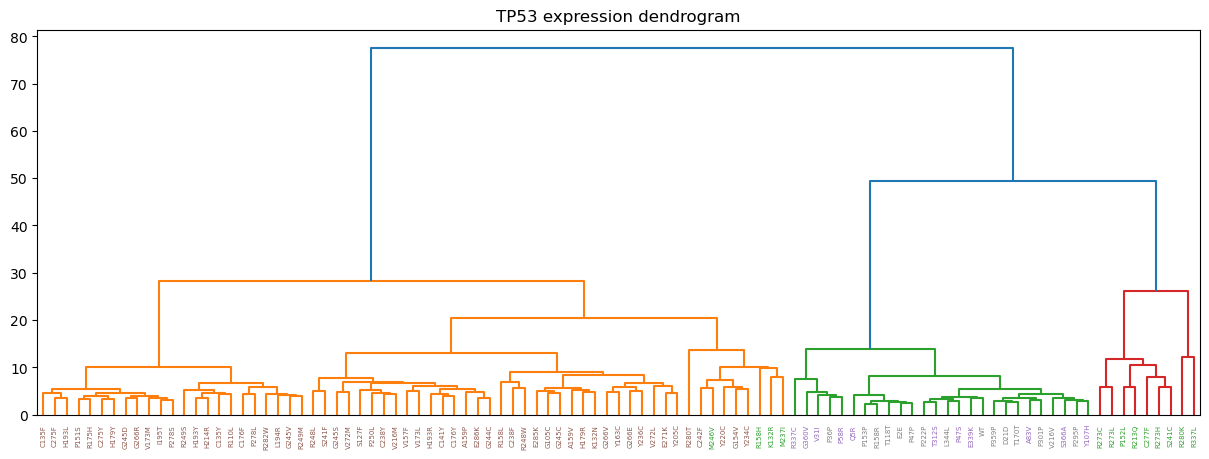

In [88]:
plt.gcf().set_size_inches(15,5)

plot_dendrogram(clustering, color_threshold = clustering.distances_[-2], labels=correl.index, orientation='top' )

for ticklabel in plt.gca().get_xticklabels():
    color_tick(ticklabel)
plt.title(f'{gene} expression dendrogram')


# Model

In [ ]:
run_name = 'TP53_020_split_cycle'
dir_name = join('models',run_name)
! cat models/{run_name}/config.ini

alpha = 0.5
batch-size = 256
config-file = models/KRAS_008_split/config.ini
task = cycle-classifier
weight-decay = 0.005
split-synon = true
loss = standard
margin = 1
dropout = 0.2
positive-fraction = 0.5
lr = 0.001
n-epochs = 600
shape = [100, 100]
embed-dim = 20
n-workers = 0
knn = 3
scheduler = plateau
patience = 40
cosine-t = 100


In [ ]:
! cat  models/{run_name}/best_score.json

{
  "3_nn_ref_seen": 0.024082346086618762,
  "i": 674
}

In [ ]:
save_dir = f'plots/var_scores/{run_name}'
make_dir_if_needed(save_dir)

## Test run : not an actual good scoring protocol

### Embeddings

In [ ]:
df_train, df_seen, df_unseen = load_split(join(dir_name, 'split'), counts, reorder_categories=False)
df_dict = {
    'train':df_train,
    'seen':df_seen,
    'unseen':df_unseen,
}

/home/lguirardel/work/sc_contrast/main.py:99: UserWarning: Not reordering categories will lead to wrong classifier prediction
  warn('Not reordering categories will lead to wrong classifier prediction')


46342, 15447, 21989 exemples in data
75 variants in train
24 variants in unseen


In [ ]:
# model = torch.load(join(dir_name,'model.pkl'), map_location='cpu')
model :Model = torch.load(join(dir_name,'best_model.pkl'), map_location='cpu')
model.eval()

CycleClassifier(
  (network): MLP(
    (layers): Sequential(
      (0): Linear(in_features=1224, out_features=100, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): ELU(alpha=1.0)
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=100, out_features=20, bias=True)
    )
  )
  (output_layer_1): Linear(in_features=20, out_features=75, bias=True)
  (output_layer_2): Linear(in_features=20, out_features=6, bias=True)
)

In [ ]:
emb_dict = {}
for k, df in df_dict.items():
    X = torch.tensor(df.drop(columns=['variant','Variant functional class', 'cycle']).to_numpy(), dtype=torch.float32)
    embeds = []
    for i,x in enumerate(X):
        with torch.no_grad():
            embeds.append(model.embed(x))
    emb_dict[k] = torch.stack(embeds)

In [ ]:
emb_dim = emb_dict['train'].size(1)
print("Embedding dimension :", emb_dim)

Embedding dimension : 20


### Scoring

In [ ]:
subset = 'seen' #unseen does not mean much as we have too few controls
df = df_dict[subset]
embeds = emb_dict[subset]

# embeds = (embeds - embeds.mean(dim=0, keepdim=True))/embeds.std(dim=0, keepdim=True)

In [ ]:
result = sceVIP_score.compare_groups_with_reference(
    pd.DataFrame(embeds, index=df.index),
    pd.DataFrame(df.variant.rename('label')),
    groups=df.variant.unique(),
    controls=control_status[control_status].index,
    n_bootstrap_controls=0
)

Found 14/14 controls
10 %

100 %

In [ ]:
result

,HotellingT2.mean,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.high,avg.pearson.mean,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.high,HotellingT2.q,avg.pearson.q
A159V,121.59651,108.016449,135.176571,0.409219,0.382042,0.436397,0.000010,0.000010
R175H,134.815697,120.695791,148.935602,0.398768,0.372535,0.425002,0.000010,0.000010
R280T,109.774836,98.357938,121.191734,0.290227,0.269951,0.310504,0.000010,0.000010
WT,14.545776,12.160792,16.93076,0.03355,0.025698,0.041401,0.704192,0.367563
C176Y,120.110241,107.275933,132.944549,0.399739,0.371787,0.427691,0.000010,0.000010
...,...,...,...,...,...,...,...,...
P250L,90.391778,78.248164,102.535392,0.328795,0.304418,0.353172,0.000010,0.000010
G266R,141.828658,124.939114,158.718201,0.455004,0.425941,0.484067,0.000010,0.000010
C176F,76.83699,68.528119,85.14586,0.316913,0.296805,0.337021,0.000010,0.000010
C141Y,99.329668,90.061302,108.598033,0.458311,0.429747,0.486875,0.000010,0.000010


In [ ]:
## code reproduced from https://github.com/klarman-cell-observatory/sc_eVIP/, 

def get_threshold_at_FDR(fdr_data,scorename,signame,FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data[signame]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=scorename,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=scorename,ascending=False)
    score_thresh_value=float(list(fdr_passed[scorename])[0])
    return(score_thresh_value)

In [ ]:
model_thr = get_threshold_at_FDR(result, scorename='HotellingT2.mean',signame='HotellingT2.q',
        FDR = 0.05)
PCA_thr = get_threshold_at_FDR(metadata, scorename='HotellingT2',signame='HotellingT2.q',
        FDR = 0.05)

### Figures

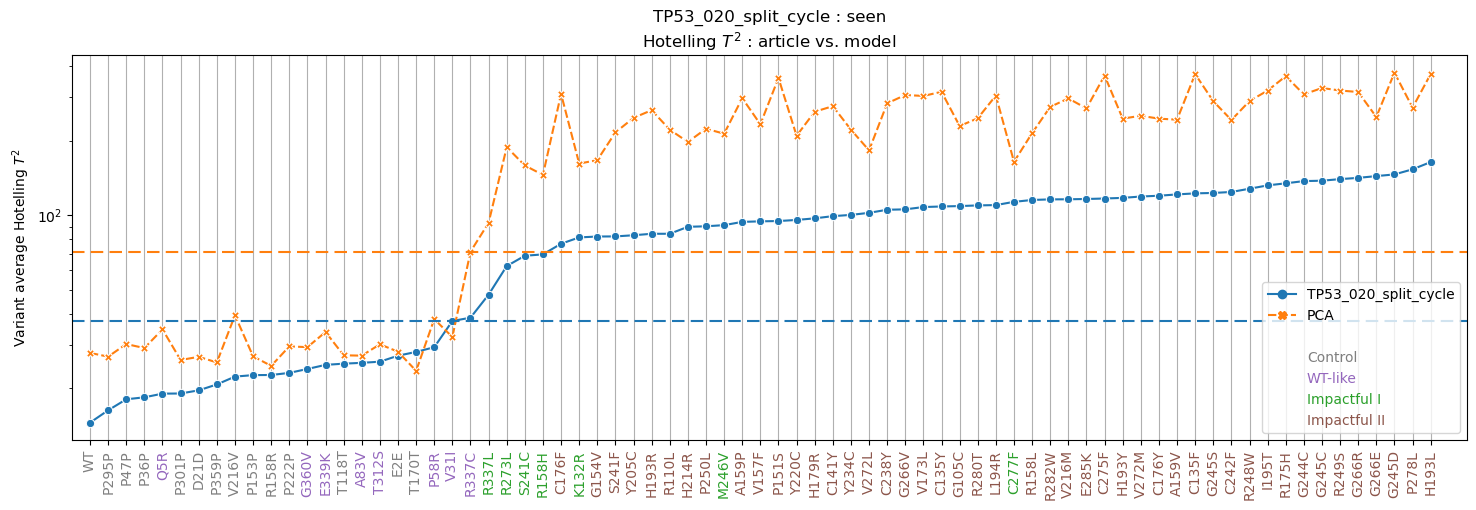

In [ ]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.mean'].rename(run_name), metadata['HotellingT2'].rename('PCA')), axis=1).dropna()
df = df.sort_values(run_name)
sns.lineplot(data=df, markers=True)
plt.yscale('log')
plt.xticks(rotation=90)

ax = plt.gca()
dashes = [6,3] 
plt.axhline(model_thr, color='C0', dashes = dashes)
plt.axhline(PCA_thr, color='C1', dashes = dashes)

for ticklabel in plt.gca().get_xticklabels():
    color_tick(ticklabel)

plt.title(f'{run_name} : {subset}\nHotelling $T^2$ : article vs. model')
plt.ylabel('Variant average Hotelling $T^2$')
plt.grid(axis='x')
# text legends
plt.axvspan(1,2, facecolor='w', alpha=0, label=' ')
plt.axvspan(1,2, facecolor='w', alpha=0, label='Control')
plt.axvspan(1,2, facecolor='w', alpha=0, label='WT-like')
plt.axvspan(1,2, facecolor='w', alpha=0, label='Impactful I')
plt.axvspan(1,2, facecolor='w', alpha=0, label='Impactful II')
if gene == 'KRAS':
    plt.axvspan(1,2, facecolor='w', alpha=0, label='Impactful III')
    plt.axvspan(1,2, facecolor='w', alpha=0, label='Impactful IV')
plt.legend(labelcolor = ['k','k','k',*variant_class_cmap.values()])
plt.xlim(-1, df.shape[0]+1)
plt.savefig(save_dir+f'/{subset}_T2.pdf');


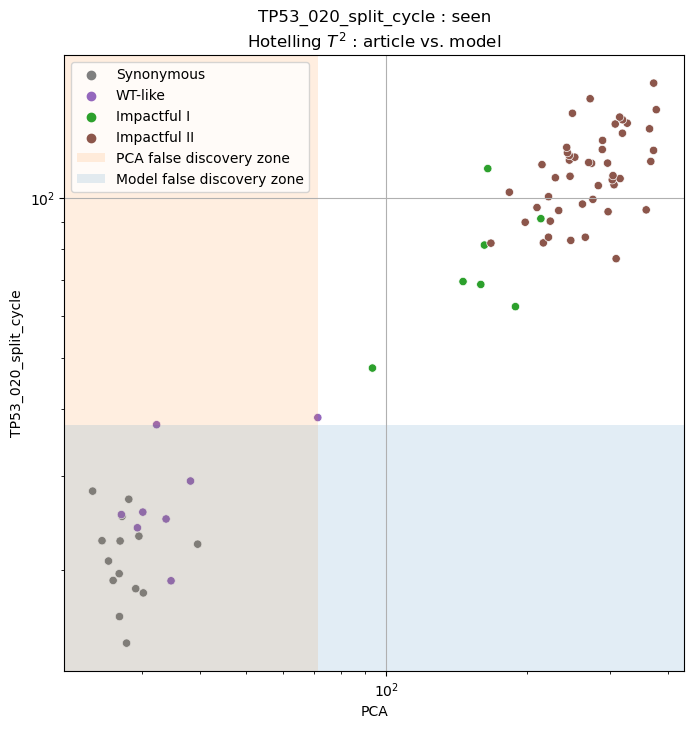

In [ ]:
plt.gcf().set_size_inches(8, 8);

hue = metadata.loc[df.index, 'Variant functional class'].copy()
hue[metadata['Control status'] == 'synonymous'] = 'Synonymous'
sns.scatterplot(df, x='PCA', y=run_name, hue=hue, palette=variant_class_cmap, hue_order=variant_class_cmap.keys())
plt.title(f'{run_name} : {subset}\nHotelling $T^2$ : article vs. model')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.axvspan(0, PCA_thr, facecolor='C1', alpha=1/8, label='PCA false discovery zone')
plt.axhspan(0, model_thr, facecolor='C0', alpha=1/8, label='Model false discovery zone')
plt.legend()
plt.savefig(save_dir+f'/{subset}_T2_scatter.pdf');

TP53 : C277F : very far from regression line ?
- it's LOF (missense) according to https://ckb.jax.org/geneVariant/show?geneVariantId=25931


... It's a gene I missed, not them

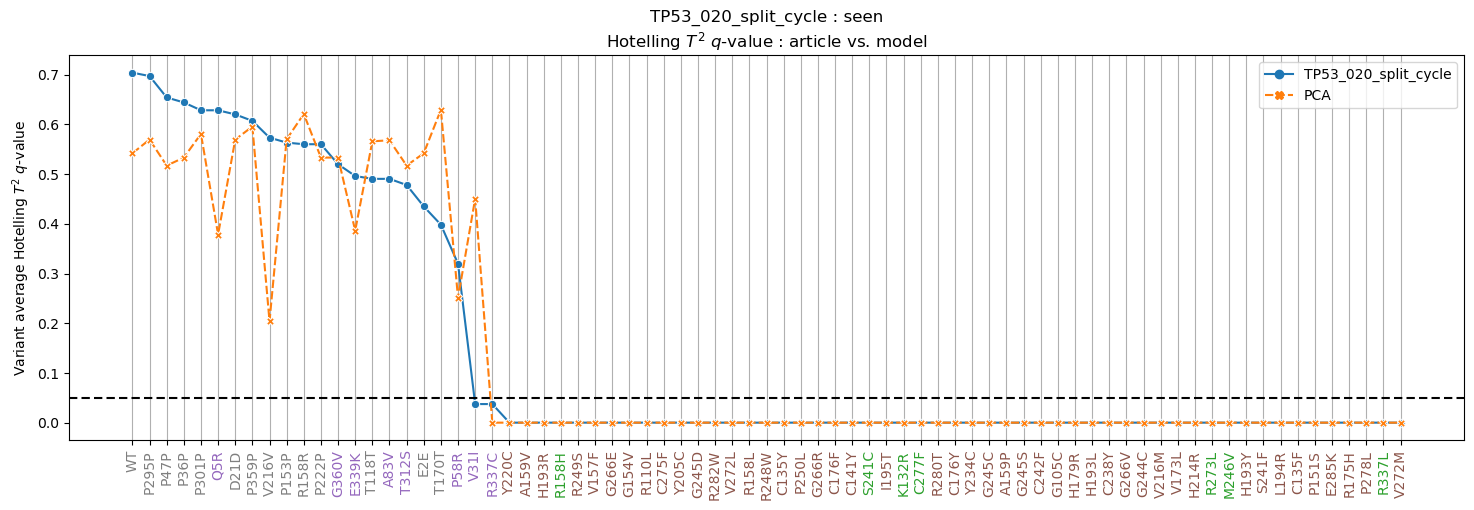

In [ ]:
plt.gcf().set_size_inches(18, 5);
df = pd.concat((result['HotellingT2.q'].rename(run_name), metadata['HotellingT2.q'].rename('PCA')), axis=1).dropna()
df = df.sort_values(run_name, ascending=False)
sns.lineplot(data=df, markers=True)
# plt.yscale('log')
plt.xticks(rotation=90)

for ticklabel in plt.gca().get_xticklabels():
   color_tick(ticklabel)

plt.title(f'{run_name} : {subset}\nHotelling $T^2$ $q$-value : article vs. model')
plt.ylabel('Variant average Hotelling $T^2$ $q$-value')
plt.grid(axis='x')
plt.axhline(0.05, dashes=[4,2], color='k')
plt.savefig(save_dir+f'/{subset}_T2_q.pdf');

## Clustering

In [64]:
subset = 'train'
df = df_dict[subset]
embeds = emb_dict[subset]

embeds = pd.DataFrame(embeds, index=df.index)

In [65]:
variant_avg = embeds.groupby(df.variant).mean()
variant_avg = variant_avg.dropna() # drop variants in other part ofsplit

In [66]:
correl = variant_avg.T.corr(method='spearman')

In [67]:
clustering = AgglomerativeClustering(n_clusters= 3 if gene == 'TP53' else 5, metric='l1',linkage='complete', compute_distances=True)
clusters = clustering.fit_predict(correl)

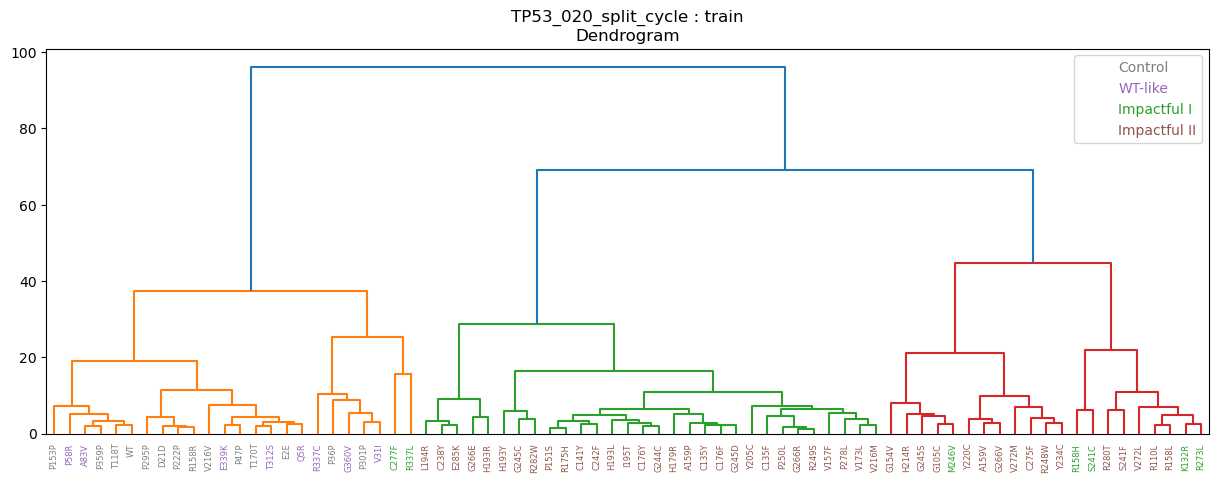

In [68]:
plt.gcf().set_size_inches(15,5)

plot_dendrogram(clustering, color_threshold = clustering.distances_[-2], labels=correl.index, orientation='top' )

for ticklabel in plt.gca().get_xticklabels():
    color_tick(ticklabel)
# text legends
plt.axvspan(1,2, facecolor='w', alpha=0, label='Control')
plt.axvspan(1,2, facecolor='w', alpha=0, label='WT-like')
plt.axvspan(1,2, facecolor='w', alpha=0, label='Impactful I')
plt.axvspan(1,2, facecolor='w', alpha=0, label='Impactful II')
if gene == 'KRAS':
    plt.axvspan(1,2, facecolor='w', alpha=0, label='Impactful III')
    plt.axvspan(1,2, facecolor='w', alpha=0, label='Impactful IV')
plt.legend(labelcolor = [*variant_class_cmap.values()])
plt.title(f"{run_name} : {subset}\nDendrogram");
plt.savefig(save_dir+f'/{subset}_dendrogram.pdf');

In [69]:
variant_class_cmap

{'Synonymous': 'C7',
 'WT-like': 'C4',
 'Impactful I': 'C2',
 'Impactful II': 'C5'}